# Multi Layer Perceptron (MLP)

MLP is one of the most popular and well known deep architectures. The functional form is 

$$
f(x; W, b, g) = g_D(W_D \dots g_3(W_3 g_2( W_2 g_1(W_1 x + b_1) + b_2 ) + b_3 ) \dots + b_D)
$$

For a $D$ layer network, at layer $i$, we have the weight matrix $W_i$, the bias vector $b_i$ and the function $g_i$, that applies elementwise to its argument.


In [11]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy as sc

## Generate the Network

We will store the weights, biases and the function handlers as three different lists.

In [46]:
import torch
import torch.autograd
from torch.autograd import Variable

# The sizes of layers from input to output
sizes = [1,2,1]

# Generate the network
g = torch.tanh
identity = lambda x: x

D = len(sizes)
Weight = []
Bias = []
Func = []
for i in range(D-1):
    # For layer i, Weights are a S_{i+1} \times S_{i} matrix
    W = Variable(torch.randn(sizes[i+1],sizes[i]).double(), requires_grad=True)
    # For layer i, Biases are a S_{i+1} \times 1 matrix (a vector)
    b = Variable(torch.randn(sizes[i+1],1).double(), requires_grad=True)
    Weight.append(W)
    Bias.append(b)
    Func.append(g)
    
#Reset the final layer to identity mapping
Func[-1] = identity

# Define the exact functional form
# x: A S_0 \times B matrix where each column is a training example with S_0 features
def mlp_fun(x, Weight, Bias, Func):
    f = Variable(x, requires_grad=False)
    NumOfLayers = len(Weight)
    for i in range(NumOfLayers):
        f = Func[i](torch.matmul(Weight[i], f) + Bias[i])
    return f

## Example Data

Consider the model 
$$
y = U_2 g(U_1 x + b_1)
$$
$U_1$ is the $R \times S_{\text{in}}$ matrix of input layer weights and $U_2$ is the
$S_{\text{out}} \times R$ output layer matrix.

* In general, the function $g$ is nonlinear but it applies to each element of the input vector separately. If $z$ is a vector 
$$
g(z) \equiv \left( \begin{array}{c} g(z_1) \\ g(z_2) \\ \vdots \\ g(z_N) \end{array}\right)
$$
* When $g(z) = z^p$ is a power function with parameter $p$ a
positive integer, this form is also known as a Waring decomposition 
of a multivariate polynomial of order $p$. Here, the dimension $R$ is known as the rank of the
decomposition.


In [47]:
N = 50
Rank = 3
x  = 2*np.random.rand(sizes[0],N)-1

class ExampleFunction(object):
    def __init__(self, insize=1, outsize=2, Rank=3):
        self.U1 = np.random.randn(Rank, sizes[0])*10
        self.U2 = np.random.randn(sizes[-1],Rank)/10
        self.b  = 5*np.random.randn(Rank, 1)
        #g = lambda z: z**4
        self.g = lambda z: np.sin(2*np.pi*z/20) 

    def __call__(self, x):
        return self.U2.dot(self.g(self.U1.dot(x) + self.b))


fun = ExampleFunction(insize=sizes[0], outsize=sizes[-1],Rank=Rank)
y = fun(x)


## Visualize Data

### 1-D

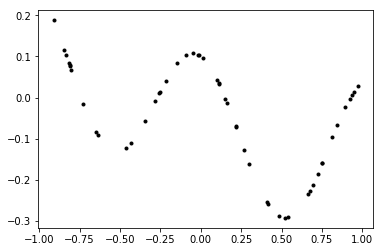

In [52]:
plt.figure()
plt.plot(x, y, 'k.')
plt.show()

### 2-D

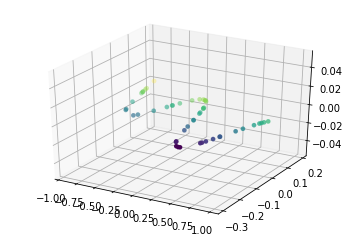

In [55]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter(x[0,:], y[0,:], c=y[0,:], cmap='viridis', linewidth=0.1);

## Training

Optimization method: A minibatch SGD algorithm with constant step size.  

/Users/veraxmedax/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


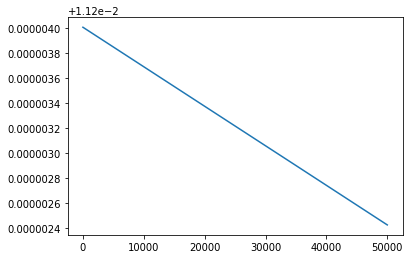

In [58]:
# Euclidian cost
Error = torch.nn.MSELoss(size_average=True)

eta = 0.0005
MAX_ITER = 50000
BatchSize = min(50, N)
EE = []
for epoch in range(MAX_ITER):
    idx = np.random.choice(N, size=BatchSize, replace=False)
    #idx = [epoch%N]
    f = mlp_fun(torch.DoubleTensor(x[:,idx]), Weight, Bias, Func)
    
    # Measure the error
    E = Error(f, Variable(torch.DoubleTensor(y[:,idx])))
    EE.append(E.data.numpy())
    
    # Compute the derivative of the error with respect to Weights and Biases
    E.backward() 
    
    # Take the step and reset weights
    for i in range(D-1):
        Weight[i].data.add_(-eta*Weight[i].grad.data)
        Bias[i].data.add_(-eta*Bias[i].grad.data)
        Weight[i].grad.zero_()
        Bias[i].grad.zero_()
        
plt.plot(EE)
plt.show()

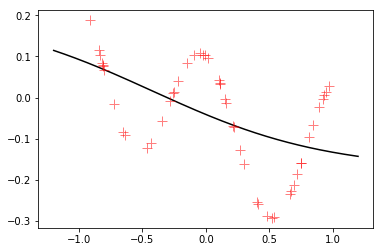

In [59]:
NN = 200
xx = np.linspace(-1.2,1.2,NN).reshape(NN,1)

f = mlp_fun(torch.DoubleTensor(xx.T), Weight, Bias, Func)
plt.plot(xx, f.data.numpy().T,'k')
#plt.plot(x, f.data.numpy(),'ko')
plt.plot(x[0,:], y[0,:],'r+',alpha=0.5, markersize=10)

plt.show()

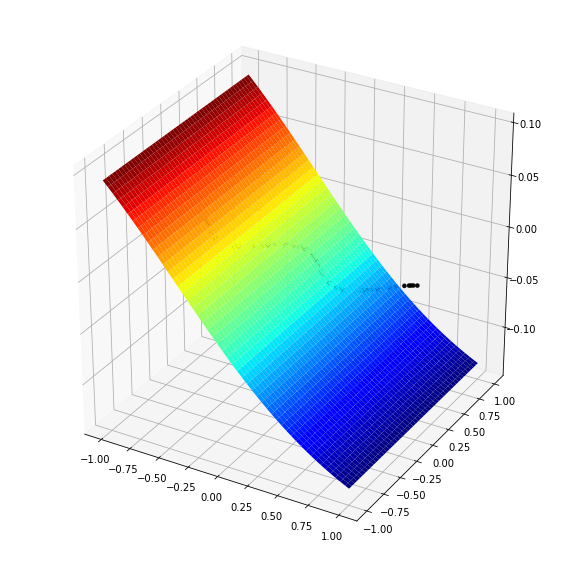

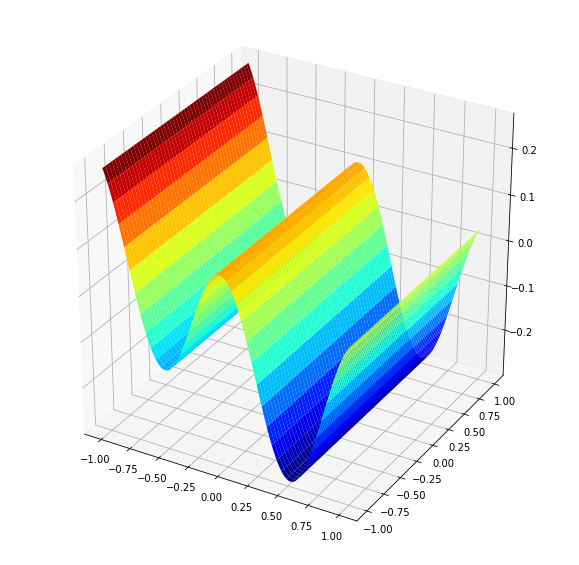

In [97]:
xx1,xx2 = np.meshgrid(np.linspace(-1,1,200), np.linspace(-1,1,200))
xx = np.c_[xx1.flatten()].T

f = mlp_fun(torch.DoubleTensor(xx), Weight, Bias, Func)
yy = f.data.numpy()[0,:].reshape(xx1.shape)

yy_true = fun(xx).reshape(xx1.shape)

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:], y[0,:], c='k', cmap='gray', linewidth=0.1);
#ax.contour3D(xx1, xx2, yy, 50, cmap='binary')
ax.plot_surface(xx1, xx2, yy, cmap='jet')
#plt.imshow(yy)
#ax.view_init(30, 20)
plt.show()

plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_surface(xx1, xx2, yy_true, cmap='jet')
plt.show()

In [98]:
from IPython.display import display, Math, Latex, HTML
import notes_utilities as nut
from importlib import reload


ModuleNotFoundError: No module named 'notes_utilities'

In [99]:
%matplotlib inline

#Code from https://gist.github.com/craffel/2d727968c3aaebd10359

import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes, bias=0):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        bias_node = (bias if n<len(layer_sizes)-1 else 0)
        for m in range(layer_size+bias_node ):
            node_color = 'w' if m<layer_size else 'b'
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/8.,
                                color=node_color, ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a+bias):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], 
                                  c='k')
                ax.add_artist(line)

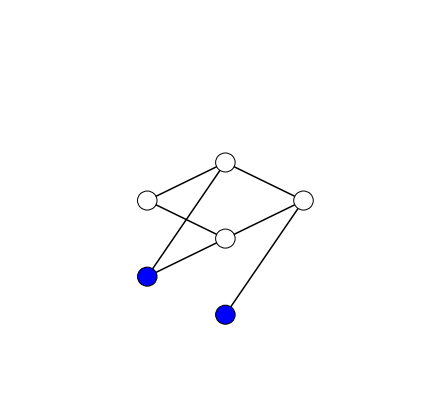

In [88]:
sizes = [1, 2, 1]
fig = plt.figure(figsize=(7, 7))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .3, .7, .3, .7, sizes, bias=1)

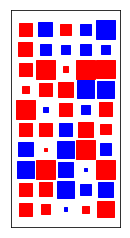

In [100]:
import numpy as np
import matplotlib.pyplot as plt


def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix."""
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('white')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'red' if w > 0 else 'blue'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()



# Fixing random state for reproducibility
np.random.seed(19680801)

hinton(np.random.rand(5, 10) - 0.5)
plt.show()